## Objectives 

<pre>
1. Preprocess all the Data we have in DonorsChoose <a href='https://drive.google.com/drive/folders/1MIwK7BQMev8f5CbDDVNLPaFGB32pFN60'>Dataset</a> use train.csv
2. Combine 4 essay's into one column named - 'preprocessed_essays'. 
3. After step 2 you have to train 3 types of models as discussed below. 
4. For all the model use <a href='https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics'>'auc'</a> as a metric. check <a href='https://datascience.stackexchange.com/a/20192'>this</a> for using auc as a metric 
5. You are free to choose any number of layers/hiddden units but you have to use same type of architectures shown below. 
6. You can use any one of the optimizers and choice of Learning rate and momentum, resources: <a href='http://cs231n.github.io/neural-networks-3/'>cs231n class notes</a>, <a href='https://www.youtube.com/watch?v=hd_KFJ5ktUc'>cs231n class video</a>. 
7. For all the model's use <a href='https://www.youtube.com/watch?v=2U6Jl7oqRkM'>TensorBoard</a> and plot the Metric value and Loss with epoch. While submitting, take a screenshot of plots and include those images in .ipynb notebook and PDF. 
8. Use Categorical Cross Entropy as Loss to minimize.
</pre>

### Model-1

Build and Train deep neural network as shown below

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



In [1]:
import pandas as pd 
resources = pd.read_csv("resources.csv")
quantity = resources["quantity"]
train = pd.read_csv("train_data.csv")
pred_data = pd.read_csv("preprocessed_data.csv")
pred_data["quantity"] = quantity


In [2]:
def hasnum(string):
    return any(i.isdigit() for i in string)
pred_data["digit_present_train"] = train["project_resource_summary"].map(hasnum).astype(int)

In [3]:
num = ["teacher_number_of_previously_posted_projects","quantity","digit_present_train","price"]
pred_data.to_csv("Final_dataset.csv")

Below is an example of embedding layer for a categorical columns. In below code all are dummy values, we gave only for referance. 

### 1. Go through this blog, if you have any doubt on using predefined Embedding values in Embedding layer - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
### 2. Please go through this link https://keras.io/getting-started/functional-api-guide/ and check the 'Multi-input and multi-output models' then you will get to know how to give multiple inputs. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from scipy.sparse import hstack
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import LSTM,Bidirectional
from keras.layers.core import Dense, Dropout
from keras.models import Model, load_model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Reshape,Concatenate
from keras.regularizers import l2
from keras.layers import LeakyReLU
import keras

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import numpy as np


Using TensorFlow backend.


### Splitting into train,cv and test

In [2]:
import pandas as pd

In [3]:
pred_data = pd.read_csv("Final_dataset.csv")

In [4]:
from sklearn.model_selection import train_test_split
Y = pred_data["project_is_approved"]
X = pred_data.drop("project_is_approved",axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2)
X_train,X_cv,y_train,y_cv=train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)


(69918, 11)
(21850, 11)
(69918,)
(21850,)


### Tokenizing 


In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import zeros

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train["essay"].tolist())

## Tokenizing the essays
train_token = tokenizer.texts_to_sequences(X_train["essay"])
test_token = tokenizer.texts_to_sequences(X_test["essay"])
cv_token = tokenizer.texts_to_sequences(X_cv["essay"])

### padding the tokenize 
max_length =300
X_train_pad = pad_sequences(train_token, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(test_token , maxlen=max_length, padding='post')
X_cv_padd = pad_sequences(cv_token, maxlen=max_length, padding='post')


#### Preparing for Embedding 
https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python

In [7]:
import pickle

glove_vector_saved = open("glove_vectors","rb") # Pepearing for embedding layers
glove_words = pickle.load(glove_vector_saved)
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = zeros((vocab_size, 300)) 
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_words.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Preprocessing Numerical and Categorical features 
https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values
https://medium.com/@davidheffernan_99410/an-introduction-to-using-categorical-embeddings-ee686ed7e7f9


In [8]:



class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [9]:
def ohe(train,cv,test,col):
    vectorizer = LabelEncoderExt() 
    vectorizer.fit(train[col].values) 

    X_train_col = vectorizer.transform(train[col].values) 
    X_cv_col = vectorizer.transform(cv[col].values)
    X_test_col = vectorizer.transform(test[col].values)
    
    return X_train_col,X_cv_col,X_test_col

https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values

In [10]:
# School State
X_train_state_ohe,X_cv_state_ohe,X_test_state_ohet = ohe(X_train,X_cv,X_test,"school_state")
# Teacher Prefix
X_train_pref_ohe,X_cv_pref_ohe,X_test_pref_ohe = ohe(X_train,X_cv,X_test,"teacher_prefix")
# Project_grade_category
X_train_pgc_ohe,X_cv_pgc_ohe,X_test_pgc_ohe = ohe(X_train,X_cv,X_test,"project_grade_category")

#clean_categories
X_train_cc_ohe,X_cv_cc_ohe,X_test_cc_ohet = ohe(X_train,X_cv,X_test,"clean_categories")

#clean_subcategories
X_train_cs_ohe,X_cv_cs_ohe,X_test_cs_ohe= ohe(X_train,X_cv,X_test,"clean_subcategories")



## Numerical features 

In [11]:
rem_input_train = np.concatenate((X_train['quantity'].values.reshape(-1,1),X_train['price'].values.reshape(-1,1),X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1),X_train["digit_present_train"].values.reshape(-1,1)),axis=1)
rem_input_test = np.concatenate((X_test['quantity'].values.reshape(-1,1),X_test['price'].values.reshape(-1,1),X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1),X_test["digit_present_train"].values.reshape(-1,1)), axis=1)
rem_input_cv = np.concatenate((X_cv['quantity'].values.reshape(-1,1),X_cv['price'].values.reshape(-1,1),X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1),X_cv["digit_present_train"].values.reshape(-1,1)), axis=1)

In [12]:
ss = StandardScaler().fit(rem_input_train)
rem_input_train_norm = ss.transform(rem_input_train)
rem_input_cv_norm = ss.transform(rem_input_cv)
rem_input_test_norm = ss.transform(rem_input_test)

### Categorical Values 

https://medium.com/@satnalikamayank12/on-learning-embeddings-for-categorical-data-using-keras-165ff2773fc9

In [13]:
from keras.utils import to_categorical


In [14]:
y_binary_train = to_categorical(y_train)
y_binary_cv = to_categorical(y_cv)
y_binary_test = to_categorical(y_test)

In [15]:
categorical_variables = cat_vars =["teacher_prefix","school_state","project_grade_category","clean_categories","clean_subcategories"]

cat_sz = {}
cat_embed_sz = {}
for cat in cat_vars:
    cat_sz[cat] = X_train[cat].nunique()
    cat_embed_sz[cat] = min(50,cat_sz[cat]//2+1)

In [17]:
ins = [] # Storing all the input layers here , since there are multiple inputs 
concat = [] # Storing all the cancatenate layers here

#### Embedding + LSTM for text_data 

In [18]:
text_input = Input(shape=(max_length,), name = "text_input") # eassyinputs 
ins.append(text_input) # appending to inputs 
embedding = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length,trainable=False)(text_input) # Embedding layer

lstm= LSTM(128,kernel_initializer='glorot_normal',recurrent_dropout=0.5,return_sequences=True)(embedding)

f1= Flatten()(lstm)
concat.append(f1)

## Embedding layers for categorical features 

In [16]:
#https://medium.com/@davidheffernan_99410/an-introduction-to-using-categorical-embeddings-ee686ed7e7f9

In [19]:
cat_vars =["teacher_prefix","school_state","project_grade_category","clean_categories","clean_subcategories"] # Categorical 

cat_sz = {}
cat_embed_sz = {}

for cat in cat_vars:
    cat_sz[cat] = X_train[cat].nunique()
    cat_embed_sz[cat] = min(50,cat_sz[cat]//2+1)
    
    
for cat in cat_vars:
    x = Input((1,), name=cat)
    ins.append(x)
    x = Embedding(cat_sz[cat]+1, cat_embed_sz[cat], input_length=1)(x)
    x = Flatten(name="flat_"+cat)(x)
    concat.append(x)

### Numerical feature Input layer

In [20]:
rem_input_layer = Input(shape=(4,),name = "rem_input_layer")
ins.append(rem_input_layer)
rem_input_dense = Dense(64, activation='relu',kernel_initializer='glorot_normal',kernel_regularizer=l2(0.001))(rem_input_layer)
concat.append(rem_input_dense)

In [21]:
x = Concatenate()(concat)

x= Dense(256,kernel_initializer='glorot_normal',kernel_regularizer=l2(0.001))(x)
x= Dropout(0.6)(x)
x= Dense(128,kernel_initializer='glorot_normal',kernel_regularizer=l2(0.001))(x)
x= Dropout(0.5)(x)
x= Dense(64,kernel_initializer='glorot_normal',kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
output=Dense(2, activation='softmax',name = "output")(x)
model_l = Model(inputs=ins, outputs=output)

In [22]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [22]:
adam = keras.optimizers.Adam(lr=0.001)
model_l.compile(optimizer=adam, loss='categorical_crossentropy',metrics=[auroc])

In [23]:
from keras.callbacks import *
filepath="model1.h5"
checkpoint_1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, mode='max')

from keras.callbacks import TensorBoard
tbCallBack = TensorBoard(log_dir='./logmod1', histogram_freq=1,
                         write_graph=True,
                         write_images=True)



earlystop_1 = EarlyStopping(monitor = 'val_loss', 
                            mode="min",
                            min_delta = 0, 
                            patience = 2,
                            verbose = 1,
                            restore_best_weights = True)

reduce_lr_1 = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, verbose = 1, min_delta = 0.0001)
callbacks_list=[tbCallBack,earlystop_1,reduce_lr_1]
batch_size=512

In [ ]:
history_1= model_l.fit({'text_input': X_train_pad, 
                        'school_state': X_train_state_ohe, 
                        'project_grade_category': X_train_pgc_ohe,
                        'clean_categories': X_train_cc_ohe,
                        'clean_subcategories':X_train_cs_ohe,
                        'teacher_prefix':X_train_pref_ohe, 
                        'rem_input_layer':rem_input_train_norm},
          y_binary_train,
          epochs=30, batch_size=batch_size,verbose=1, 
                       validation_data=({'text_input':X_cv_padd, 
                                         'school_state': X_cv_state_ohe,
                                         'project_grade_category': X_cv_pgc_ohe,
                                         'clean_categories': X_cv_cc_ohe,
                                         'clean_subcategories':X_cv_cs_ohe, 
                                         'teacher_prefix':X_cv_pref_ohe,
                                         'rem_input_layer':rem_input_cv_norm},
          y_binary_cv),callbacks=callbacks_list)


<img src="log_1.png">

<img src="model1.png">

<img src="plot_1.png">

Use the same model as above but for 'input_seq_total_text_data' give only some words in the sentance not all the words. Filter the words as below. 

<pre>
1. Train the TF-IDF on the Train data <br>
2. Get the idf value for each word we have in the train data. <br>
3. Remove the low idf value and high idf value words from our data. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very frequent words and very very rare words don't give much information. (you can plot a box plots and take only the idf scores within IQR range and corresponding words)<br>
4. Train the LSTM after removing the Low and High idf value words. (In model-1 Train on total data but in Model-2 train on data after removing some words based on IDF values)
</pre>

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
tfidf = TfidfVectorizer()
tf_ess = tfidf.fit_transform(X_train["essay"]) # Tf-Idf
dict_ess = dict(zip(tfidf.get_feature_names(),list(tfidf.idf_)))
tfidf_dataframe = pd.DataFrame(list(dict_ess.items()),columns= ["Words","Values"]) # converting tfidf into dataframe
tfidf_dataframe = tfidf_dataframe.sort_values(by="Values")             


In [11]:
tfidf_dataframe.head()

,Words,Values
40639,students,1.007724
28289,nannan,1.045410
37030,school,1.161311
28187,my,1.246864
24529,learning,1.363673


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

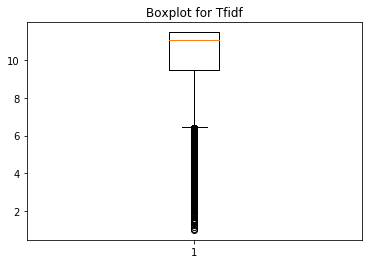

In [13]:
plt.title("Boxplot for Tfidf")
plt.boxplot(tfidf_dataframe["Values"])
plt.show()

In [14]:
print("5 percentile")
print(np.percentile(tfidf_dataframe["Values"],[5]))
print("10 percentile")
print(np.percentile(tfidf_dataframe["Values"],[10]))
print("25 percentile")
print(np.percentile(tfidf_dataframe["Values"],[25]))
print("75 percentile")
print(np.percentile(tfidf_dataframe["Values"],[75]))
print("99 percentile")
print(np.percentile(tfidf_dataframe["Values"],[99]))

5 percentile
[6.1812831]
10 percentile
[7.45461234]
25 percentile
[9.44704251]
75 percentile
[11.46194553]
99 percentile
[11.46194553]


In [15]:
len(tfidf_dataframe)

47472

### selecting features more than 9 and less than 11

In [16]:
tfidf_25_75= tfidf_dataframe[(tfidf_dataframe["Values"] >= 9.44704251 ) & (tfidf_dataframe["Values"] <= 11.46194553)]
Words = tfidf_25_75["Words"].tolist()

        

In [68]:
fil_words = tfidf_dataframe["Words"].tolist()

In [69]:
tokenizer_tf = Tokenizer()
tokenizer_tf.fit_on_texts(fil_words)

## Tokenizing the essays
train_token_tf = tokenizer.texts_to_sequences(X_train["essay"])
test_token_tf = tokenizer.texts_to_sequences(X_test["essay"])
cv_token_tf = tokenizer.texts_to_sequences(X_cv["essay"])

vocab_size = len(tokenizer_tf.word_index) + 1


### padding the tokenize 
max_length =300
X_train_pad_tf = pad_sequences(train_token_tf, maxlen=max_length, padding='post')
X_test_pad_tf = pad_sequences(test_token_tf , maxlen=max_length, padding='post')
X_cv_padd_tf = pad_sequences(cv_token_tf, maxlen=max_length, padding='post')

In [70]:
embedding_matrix_tf = zeros((vocab_size, 300))
for word, i in tokenizer_tf.word_index.items():
    embedding_vector_tf = glove_words.get(word)
    if embedding_vector_tf is not None:
        embedding_matrix_tf[i] = embedding_vector_tf

In [71]:
ins_tf = [] # Storing all the input layers here 
concat_tf = [] # Storing all the cancatenate layers here

In [55]:
text_input = Input(shape=(max_length,), name = "text_input") # eassyinputs 
ins_tf.append(text_input) # appending to inputs 
E1 = Embedding(vocab_size, 300, weights=[embedding_matrix_tf], input_length=max_length,trainable=False)(text_input) # Embedding layer

lstm= LSTM(128,kernel_initializer='glorot_normal',recurrent_dropout=0.5,return_sequences=True)(E1)

f1= Flatten()(lstm)
concat_tf.append(f1)

In [56]:
cat_vars =["teacher_prefix","school_state","project_grade_category","clean_categories","clean_subcategories"] # Categorical 

cat_sz = {}
cat_embed_sz = {}

for cat in cat_vars:
    cat_sz[cat] = X_train[cat].nunique()
    cat_embed_sz[cat] = min(50,cat_sz[cat]//2+1)
    
    
for cat in cat_vars:
    x = Input((1,), name=cat)
    ins_tf.append(x)
    x = Embedding(cat_sz[cat]+1, cat_embed_sz[cat], input_length=1)(x)
    x = Flatten(name="flat_"+cat)(x)
    concat_tf.append(x)

In [57]:
rem_input_layer = Input(shape=(4,),name = "rem_input_layer")
ins_tf.append(rem_input_layer)
rem_input_dense = Dense(64, activation='relu',kernel_initializer='glorot_normal',kernel_regularizer=l2(0.001))(rem_input_layer)
concat_tf.append(rem_input_dense)

In [58]:
x = Concatenate()(concat_tf)

x= Dense(256,kernel_initializer='glorot_normal',kernel_regularizer=l2(0.001))(x)
x= Dropout(0.6)(x)
x= Dense(128,kernel_initializer='glorot_normal',kernel_regularizer=l2(0.001))(x)
x= Dropout(0.5)(x)
x= Dense(64,kernel_initializer='glorot_normal',kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
output_tf=Dense(2, activation='softmax',name = "output")(x)
model_2 = Model(inputs=ins_tf, outputs=output_tf)

In [60]:
adam = keras.optimizers.Adam(lr=0.001)
model_2.compile(optimizer=adam, loss='categorical_crossentropy',metrics=[auroc])





In [61]:
from keras.callbacks import *
filepath="model1.h5"
checkpoint_1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, mode='max')

from keras.callbacks import TensorBoard
tbCallBack = TensorBoard(log_dir='./logmod1', histogram_freq=1,
                         write_graph=True,
                         write_images=True)



earlystop_1 = EarlyStopping(monitor = 'val_loss', 
                            mode="min",
                            min_delta = 0, 
                            patience = 2,
                            verbose = 1,
                            restore_best_weights = True)

reduce_lr_1 = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, verbose = 1, min_delta = 0.0001)
callbacks_list=[tbCallBack,earlystop_1,reduce_lr_1]
batch_size=512

In [ ]:
history_2= model_2.fit({'text_input': X_train_pad_tf, 
                        'school_state': X_train_state_ohe, 
                        'project_grade_category': X_train_pgc_ohe,
                        'clean_categories': X_train_cc_ohe,
                        'clean_subcategories':X_train_cs_ohe,
                        'teacher_prefix':X_train_pref_ohe, 
                        'rem_input_layer':rem_input_train_norm},
          y_binary_train,
          epochs=30, batch_size=batch_size,verbose=1, 
                       validation_data=({'text_input':X_cv_padd_tf, 
                                         'school_state': X_cv_state_ohe,
                                         'project_grade_category': X_cv_pgc_ohe,
                                         'clean_categories': X_cv_cc_ohe,
                                         'clean_subcategories':X_cv_cs_ohe, 
                                         'teacher_prefix':X_cv_pref_ohe,
                                         'rem_input_layer':rem_input_cv_norm},
          y_binary_cv),callbacks=callbacks_list)


<img src="log_2.png">

<img src="model2.png">

<br> Here we see that after 7th epoch the model tends to overfit </br>

<img src="plot_2.png">

### Model-3

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png


- __input_seq_total_text_data__: <br>
<pre>
    . Use text column('essay'), and use the Embedding layer to get word vectors. <br>
    . Use given predefined glove word vectors, don't train any word vectors. <br>
    . Use LSTM that is given above, get the LSTM output and Flatten that output. <br>
    . You are free to preprocess the input text as you needed. <br>
</pre>
- __Other_than_text_data__:<br>
<pre>
    . Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors <br>
    . Neumerical values and use <a href='https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions'>CNN1D</a> as shown in above figure. <br>
    . You are free to choose all CNN parameters like kernel sizes, stride.<br>
    
</pre>

In [63]:
from sklearn.feature_extraction.text import CountVectorizer

In [64]:
def countohe(col):
    vec  = CountVectorizer()
    X_train_ht = vec.fit_transform(X_train[col])
    X_cv_ht = vec.fit_transform(X_cv[col])
    X_test_ht = vec.fit_transform(X_test[col])
    return X_train_ht,X_cv_ht,X_test_ht


In [66]:
a,b,c = countohe("teacher_prefix")

In [71]:
X_train_state,X_cv_state,X_test_state = countohe("school_state")
# Teacher Prefix
X_train_pref,X_cv_pref,X_test_pref = countohe("teacher_prefix")
# Project_grade_category
X_train_pgc,X_cv_pgc,X_test_pg = countohe("project_grade_category")

#clean_categories
X_train_cc,X_cv_cc,X_test_cc = countohe("clean_categories")

#clean_subcategories
X_train_cs,X_cv_cs,X_test_cs = countohe("clean_subcategories")

In [84]:

### input 2
x_train_3 = hstack((X_train_state,X_train_pref,X_train_pgc,X_train_cc, X_train_cs,rem_input_train_norm)).todense()
x_train_3 = np.array(x_train_3).reshape(x_train_3.shape[0],x_train_3.shape[1],1)



x_test_3 = hstack((X_test_state,X_test_pref,X_test_pg,X_test_cc, X_test_cs,rem_input_test_norm)).todense()
x_test_3 = np.array(x_test_3).reshape(x_test_3.shape[0],x_test_3.shape[1],1)

x_CV_3 = hstack((X_cv_state,X_cv_pref,X_cv_pgc,X_cv_cc, X_cv_cs,rem_input_cv_norm)).todense()
x_CV_3 = np.array(x_CV_3).reshape(x_CV_3.shape[0],x_CV_3.shape[1],1)







In [85]:
x_train_3.shape


(69918, 103, 1)

In [86]:
rem_input_cv_norm.shape

(17480, 4)

In [89]:
from keras.layers import Conv1D

In [95]:
## essay Text
input_a = Input(shape=(max_length,))
E1 = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length,trainable=False)(input_a)# Embedding layer
X1 = Dropout(0.3)(E1)
X1 = LSTM(128,return_sequences=True)(X1)
X1 = Flatten()(X1)


In [99]:

## Categorical and Numerical
input_2 = Input(shape=(103,1))
X2 = Conv1D(filters=128,kernel_size=3,strides=1)(input_2)
X2 = Conv1D(filters=64,kernel_size=3,strides=1)(X2)
X2 = Flatten()(X2)



In [106]:
# Mergeing the inputs
concat = Concatenate(axis=1)([X1,X2])
X_f = Dense(128,activation='relu',kernel_regularizer=l2(0.0001))(concat)
X_f = Dropout(0.5)(X_f)
X_f = Dense(64,activation='relu',kernel_regularizer=l2(0.0001))(X_f)
X_f = Dropout(0.5)(X_f)
X_f = BatchNormalization()(X_f)
X_f = Dense(32,activation='relu',kernel_regularizer=l2(0.0001))(X_f)
X_f = Dropout(0.5)(X_f)
output = Dense(2, activation = 'softmax')(X_f)



In [109]:
model_3 =Model([input_a,input_2],output)


In [110]:
adam = keras.optimizers.Adam(lr=0.001)
model_3.compile(optimizer=adam, loss='categorical_crossentropy',metrics=[auroc])

In [115]:
x_train = [X_train_pad, x_train_3]
x_test  = [X_cv_padd, x_CV_3]

In [118]:
x_CV_3.shape

(17480, 103, 1)

<img src="log3.png">

<img src="model3.png">

<br> So far the model does not overfit and the loss also converges </br>


<img src="plot_3.png">